In [3]:
import os
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
import seaborn as sns

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# paths
import yaml
config = yaml.safe_load(open('../config.yaml', "r"))
data_path = config['DOWNDIR']
SDIR = config['DIR']
# output from snakemake (tables)
table_path = '/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/'
# path for figures
figure_path = '../figures/'
# path for supplemental figures and tables
supp_path = '../supplement/'

dayfirst = True

/tmp/ipykernel_2500160/4201163370.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Load Data

In [4]:
# get index of datasets
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name and 'protein' not in name: 
            h5_files[name.split('.h5')[0]] = os.path.join(path, name)
datasets = list(h5_files.keys())
# print(len(datasets))

In [5]:
# capture obs and vars in a dict, indices as keys
obses = {}
vares = {}
for name, path in tqdm(h5_files.items(), leave=False):
    obses[name] = pd.read_csv(os.path.dirname(path)+'/obs.csv')
    vares[name] = pd.read_csv(os.path.dirname(path)+'/var.csv')

  0%|          | 0/35 [00:00<?, ?it/s]

/tmp/ipykernel_2500160/1035502437.py:5: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  obses[name] = pd.read_csv(os.path.dirname(path)+'/obs.csv')
/tmp/ipykernel_2500160/1035502437.py:5: DtypeWarning: Columns (6,15,16,28) have mixed types. Specify dtype option on import or set low_memory=False.
  obses[name] = pd.read_csv(os.path.dirname(path)+'/obs.csv')


In [8]:
# This is the excel table on the datasets (metadata)
metadata= pd.read_csv("../metadata/scperturb_dataset_info_140922.csv", index_col=0)
metadata['dataset_id'] = [i if pd.isna(x) else f'{i}_{x}' for i, x in zip(metadata.index, metadata.dataset_index)]
metadata = metadata.set_index('dataset_id')
metadata.head()

,dataset_index,Title,doi/url,First Author,Organisms,Modality = Data type,Method,Tissues,Number of perturbations (incl. unperturbed),Perturbation,disease,celltype,tissue type,Cancer,multiple time points?,multiple concentrations?,combined perturbations?,Date of Submission,Year,Mini-Abstract (loosely summarized original Abstract)
dataset_id,,,,,,,,,,,,,,,,,,,,
AdamsonWeissman2016_GSM2406675_10X001,GSM2406675_10X001,A multiplexed single-cell CRISPR screening pla...,https://doi.org/10.1016/j.cell.2016.11.048,Britt Adamson,Homo sapiens,RNA,Perturb-seq,K562,9,CRISPRi,Chronic myeloid leukemia,lymphoblasts,cell_line,y,n,n,n,01.10.2019,2019,Perturb-seq is applied to dissect the mammalia...
AdamsonWeissman2016_GSM2406677_10X005,GSM2406677_10X005,A multiplexed single-cell CRISPR screening pla...,https://doi.org/10.1016/j.cell.2016.11.048,Britt Adamson,Homo sapiens,RNA,Perturb-seq,K562,20,CRISPRi,Chronic myeloid leukemia,lymphoblasts,cell_line,y,n,n,y,01.10.2019,2019,Perturb-seq is applied to dissect the mammalia...
AdamsonWeissman2016_GSM2406681_10X010,GSM2406681_10X010,A multiplexed single-cell CRISPR screening pla...,https://doi.org/10.1016/j.cell.2016.11.048,Britt Adamson,Homo sapiens,RNA,Perturb-seq,K562,114,CRISPRi,Chronic myeloid leukemia,lymphoblasts,cell_line,y,n,n,y,01.10.2019,2019,Perturb-seq is applied to dissect the mammalia...
AissaBenevolenskaya2021,NaN,Single-cell transcriptional changes associated...,https://doi.org/10.1038/s41467-021-21884-z,Alexandre Aissa,Homo sapiens; Mus musculus,RNA,Drop-Seq,"cell lines, patient tissue, mouse xenografts",4,drugs,Lung adenocarcinoma,Lung adenocarcinoma,cell_line,y,no,n,y,01.11.2020,2020,This study uses scRNA-seq to demonstrate the e...
ChangYe2021,NaN,Identifying transcriptional programs underlyin...,https://doi.org/10.1038/s41587-021-01005-3,Matthew Chang,Homo sapiens,RNA,clonal tagging (TraCe-seq),"lung and breast cancer cell lines PC9, MCF-10A...",4,drugs,lung adenocarcinoma,Lung adenocarcinoma,cell_line,y,n,n,n,01.08.2021,2021,By conducting clonal fitness mapping and scRNA...


# Prepare and aggregate QC

In [9]:
# delete datasets from obses where the column 'ncounts' is missing
K = list(obses.keys())
for name in K:
    if 'ncounts' not in obses[name].columns:
        print(name)
        del obses[name]
# delete datasets from vares where the column 'ncounts' is missing
K = list(vares.keys())
for name in K:
    if 'ncounts' not in vares[name].columns:
        print(name)
        del vares[name]

In [10]:
# Extract Cell-wise QC
num_obs_keys = ['ncounts', 'ngenes', 'percent_mito', 'percent_ribo', # numerical vector
                'perturbation_type' # and annotations
               ]  
ddict = {name: obs[num_obs_keys] for name, obs in obses.items()}
df = pd.concat(ddict).reset_index(level=0)
df.columns = ['dataset'] + num_obs_keys
df.dataset = df.dataset.replace({'McFarlandTshemiak2020_all_expts_combined': 'McFarlandTsherniak2020'})  # typo

# Extract Gene-wise QC
num_var_keys = ['ncounts', 'ncells']  # numerical vector
num_data = []
for var_key in num_var_keys:
    num_data.append([var[var_key].values for name, var in vares.items()])
ddict = {name: var[num_var_keys] for name, var in vares.items()}
df_ = pd.concat(ddict).reset_index(level=0)
df_.columns = ['dataset'] + num_var_keys
df_.dataset = df_.dataset.replace({'McFarlandTshemiak2020_all_expts_combined': 'McFarlandTsherniak2020'})  # typo

In [12]:
# add more detailed perturbation_type annotation
df['perturbation_type_'] = None
for dataset in tqdm(pd.unique(df.dataset)):
    val = metadata.loc[dataset, 'Perturbation'].replace(', TCR stim', '')
    df.loc[df.dataset==dataset, 'perturbation_type_'] = val
    df_.loc[df_.dataset==dataset, 'perturbation_type_'] = val

  0%|          | 0/35 [00:00<?, ?it/s]

In [21]:
# sort boxes by perturbation type and within perturbation types sort by name
counts = df.value_counts(['dataset', 'perturbation_type_'], sort=False).reset_index()
order = counts.sort_values(['perturbation_type_', 'dataset'], ascending=True).dataset.values

In [15]:
# set colors
colors_perturbation_types = {
    'CRISPRi': 'tab:blue', 
    'CRISPRa': 'tab:red', 
    'CRISPR': 'tab:orange',
    'CRISPR-cas9': 'tab:orange',
    'drugs': 'tab:green',
    'drug': 'tab:green',
    'cytokine': 'tab:olive',
    'cytokines': 'tab:olive',
    'drugs, CRISPR-cas9': 'tab:pink',
    'CRISPR-cas9, TCR stim': 'tab:purple'
}

# Fig3C

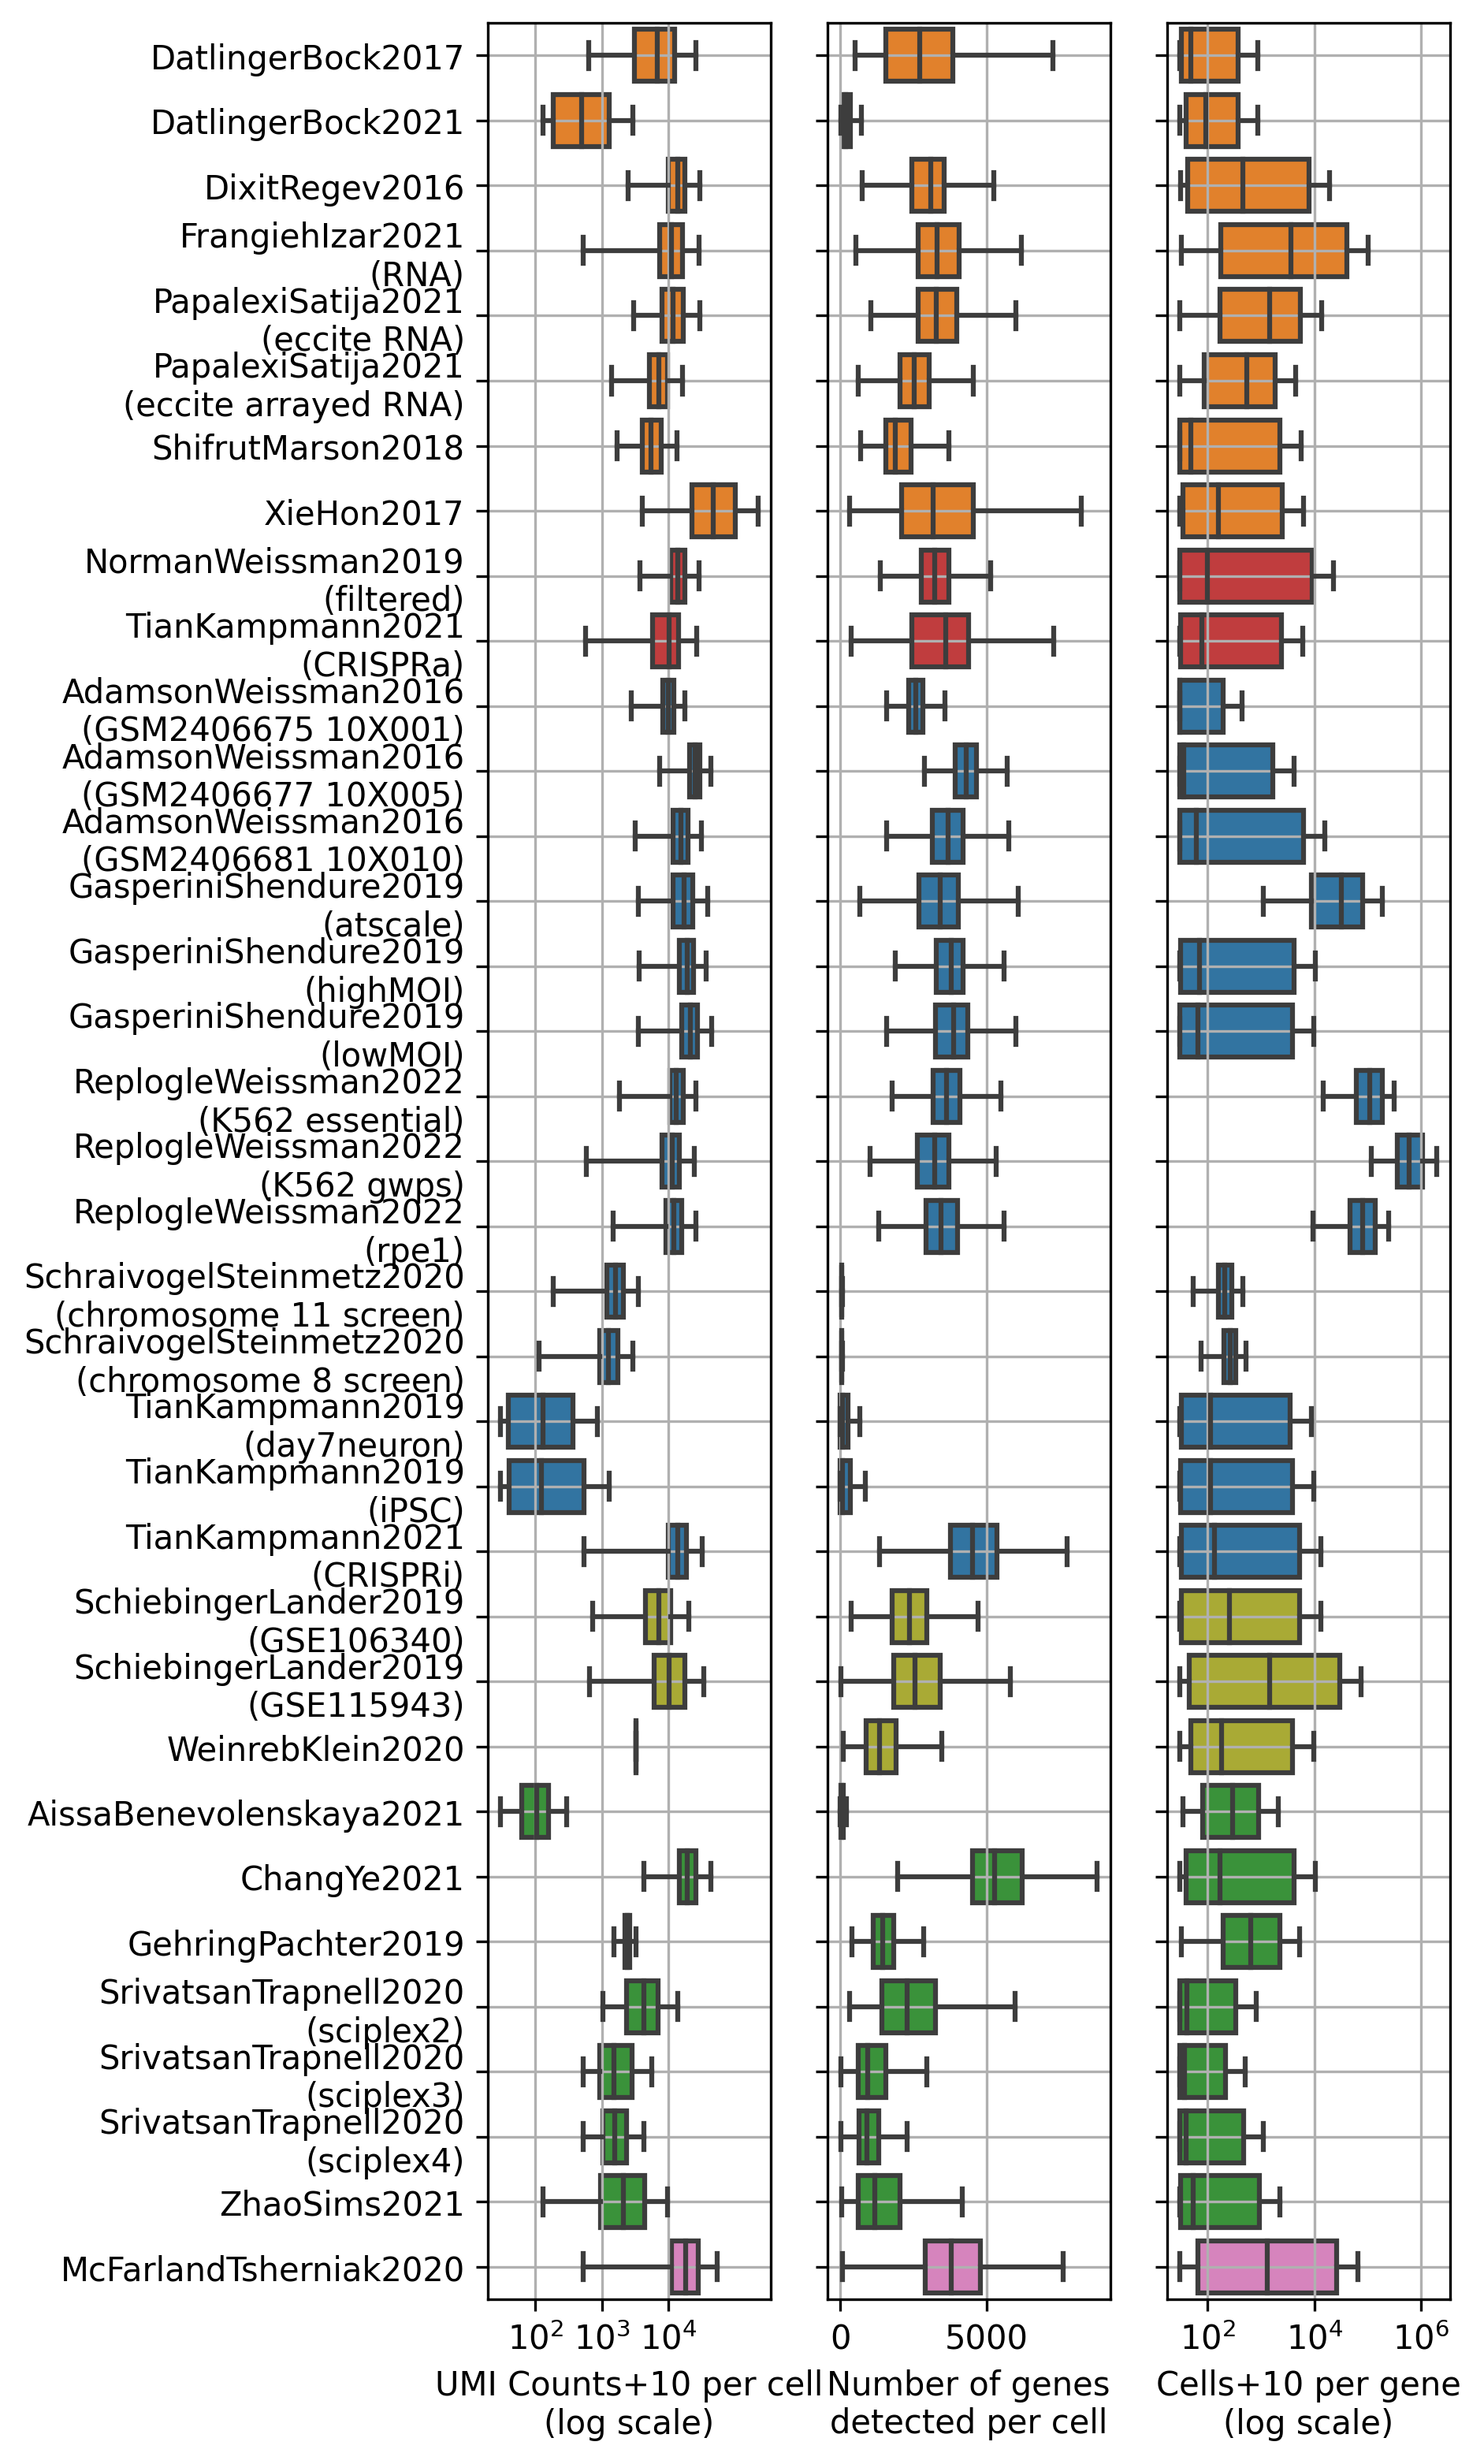

In [22]:
# options
pseudocounts = 10
kwargs = {'showfliers': False, 'hue': 'perturbation_type_', 'zorder': 5, 'palette': colors_perturbation_types, 'order': order, 'dodge': False}

# setup figure
# with sns.axes_style("whitegrid"):
scale = 0.75
fig, axs = pl.subplots(1, 3, figsize=[7*scale, 17*scale], sharey=True, dpi=300)

# First row ncounts (obs)
ax = axs[0]
df['ncounts'] += pseudocounts
bp = sns.boxplot(data=df, y='dataset', x='ncounts', ax=ax, **kwargs)
ax.set_xlabel(f'UMI Counts+{pseudocounts} per cell\n(log scale)')
ax.set_xscale('log')
ax.set_ylabel('')
bp.legend_.remove()
ax.grid()
ax.set_xticks([1e2, 1e3, 1e4])

# Second row ngenes
ax = axs[1]
bp = sns.boxplot(data=df, y='dataset', x='ngenes', ax=ax, **kwargs)
ax.set_xlabel('Number of genes\ndetected per cell')
# ax.set_title('Genes Expressed')
ax.set_ylabel('')
ax.grid()
bp.legend_.remove()

# Third row ncells
ax = axs[2]
df_['ncells'] += pseudocounts
bp = sns.boxplot(data=df_, y='dataset', x='ncells', ax=ax, **kwargs)
ax.set_xlabel(f'Cells+{pseudocounts} per gene\n(log scale)')
ax.set_xscale('log')
ax.set_ylabel('')
ax.grid()
ax.set_xticks([1e2, 1e4, 1e6])
bp.legend_.remove()
    
# xticks and labels
dataset_names = order
dataset_names = [x.replace('TAP_SCREEN__', '') for x in dataset_names]
dataset_names = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in dataset_names]
dataset_names = [x.replace('_', ' ') for x in dataset_names]
axs[-1].set_yticks(np.arange(len(dataset_names)))
axs[-1].set_yticklabels(dataset_names, rotation=90)
pl.savefig(f'{figure_path}/Fig3C_updated.pdf', bbox_inches='tight')
pl.show()

# Fig3B

In [23]:
keys = obses.keys()
keys = ['McFarlandTsherniak2020' if 'McFarland' in name else name for name in keys]  # typo
tab = pd.DataFrame(index=keys)
for name, obs in obses.items():
    tab.loc[name, 'mean counts per cell'] = np.mean(obs.ncounts)
    tab.loc[name, 'mean genes expressed per cell'] = np.mean(obs.ngenes)
    tab.loc[name, 'number of perturbations'] = len(pd.unique(obs.perturbation))
    tab.loc[name, 'number of perturbations (log)'] = np.log(len(pd.unique(obs.perturbation)))
    tab.loc[name, 'number of cells'] = len(obs)
    tab.loc[name, 'mean number of cells per perturbation'] = np.mean(obs.value_counts('perturbation'))
    tab.loc[name, 'modality'] = 'protein' if 'protein' in name else 'RNA'
    tab.loc[name, 'year'] = int(name.split('_')[0][-4:])
    tab.loc[name, 'Date of Submission'] = pd.to_datetime(metadata.loc[name, 'Date of Submission'], dayfirst= dayfirst)
    tab.loc[name, 'perturbation type'] = metadata.loc[name, 'Perturbation'].replace(', TCR stim', '')
    for cat_key in ['tissue_type', 'cancer', 'organism']:
        tab.loc[name, cat_key] = pd.unique(obs[cat_key])[0] if cat_key in obs.keys() else None
    tab.loc[name, 'dataset'] = name

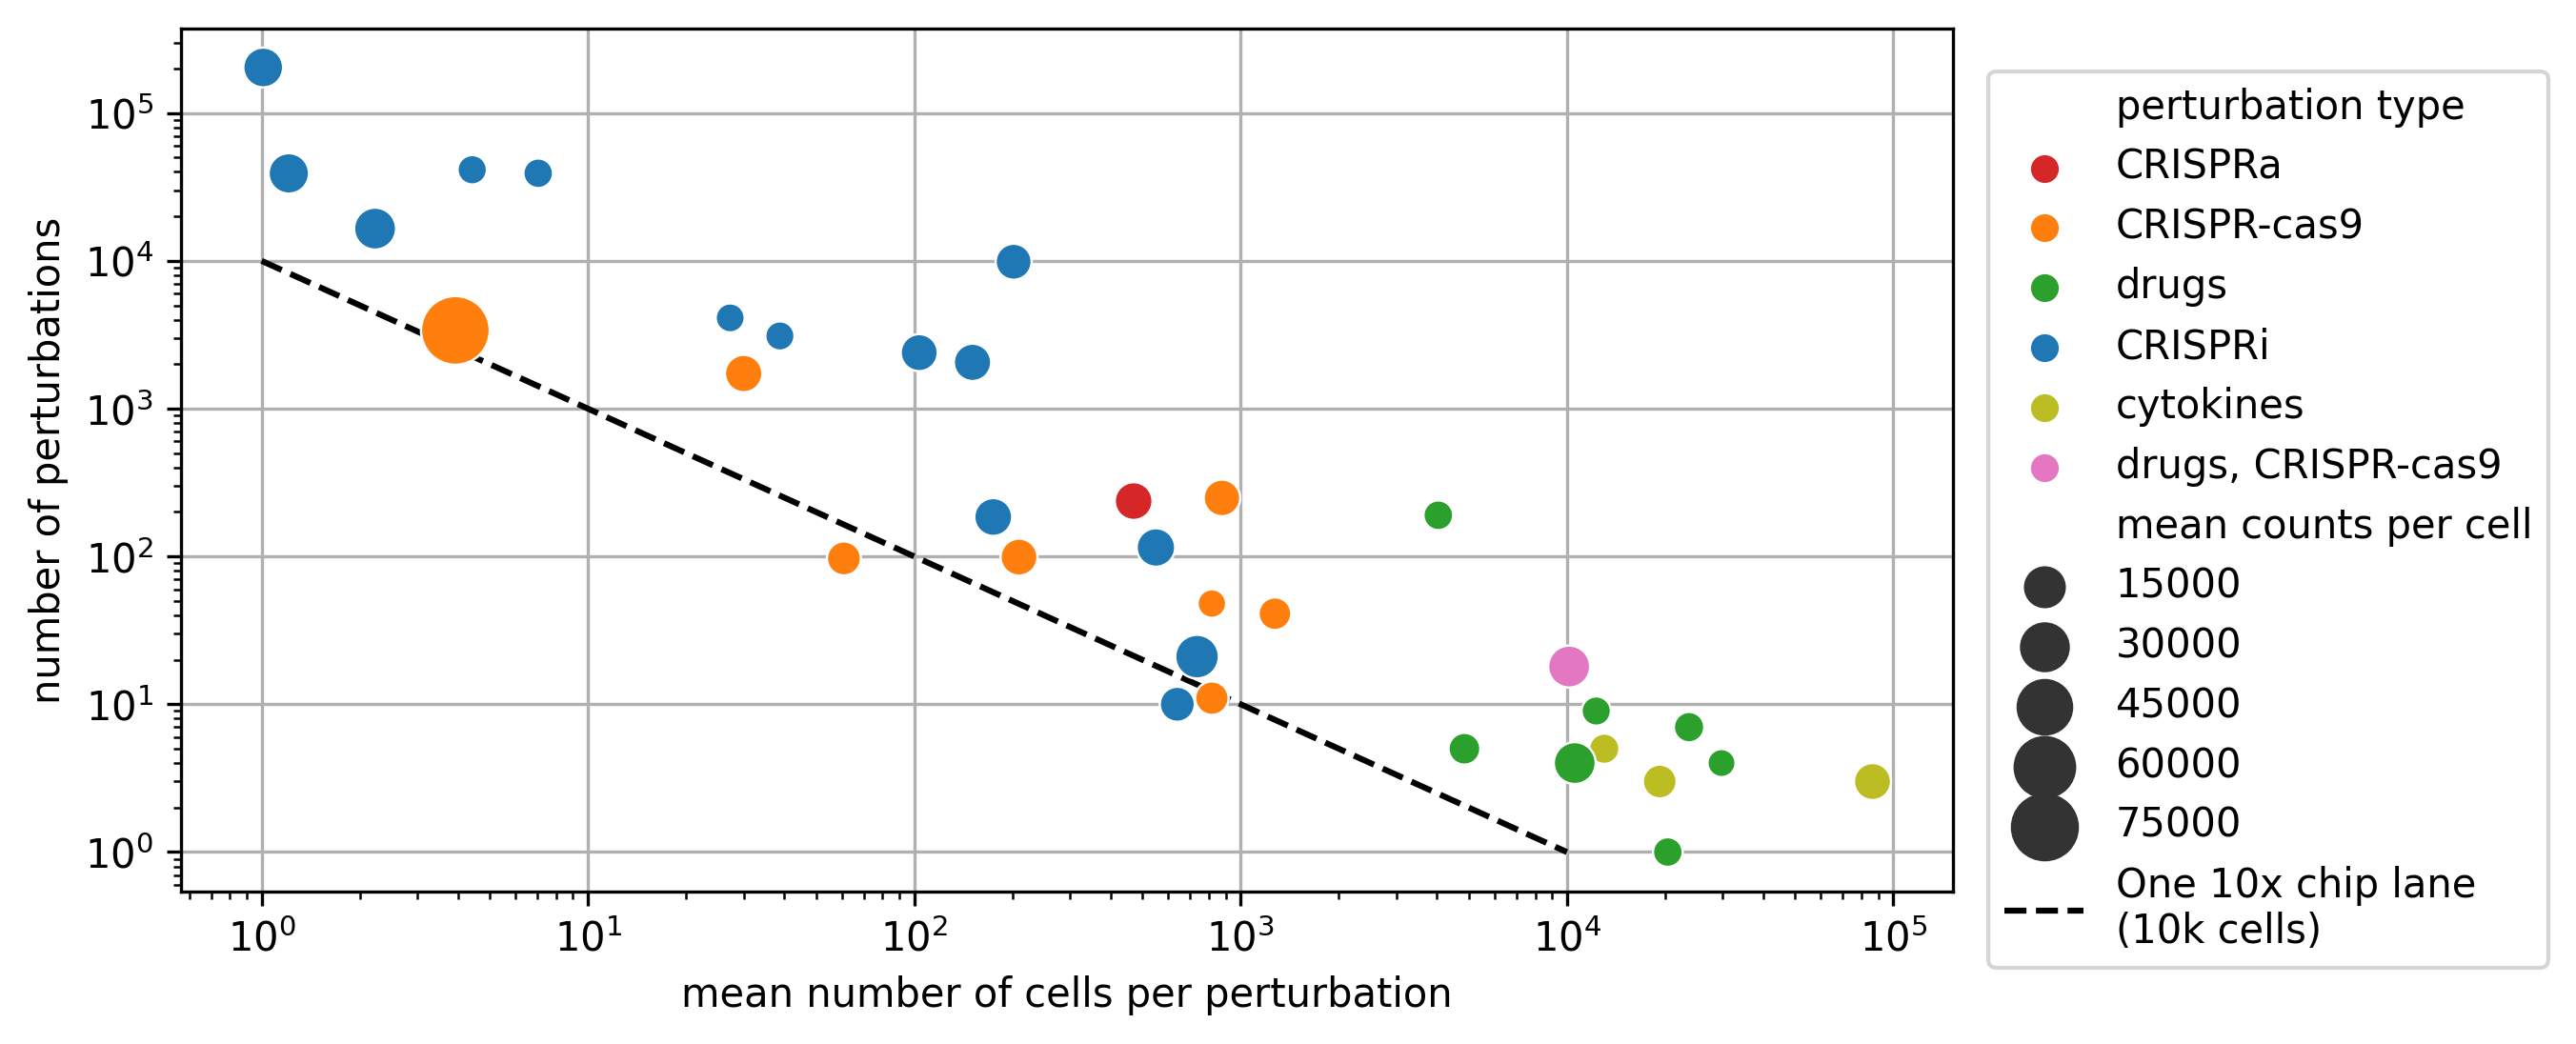

In [24]:
fig, ax = pl.subplots(figsize=[8,4], dpi=300)
sns.scatterplot(data=tab, x='mean number of cells per perturbation', y='number of perturbations', palette=colors_perturbation_types,
                hue='perturbation type', size='mean counts per cell', sizes=(50,300), zorder=3)
ax.plot([1, 1e4], [1e4, 1], 'k--', label='One 10x chip lane\n(10k cells)')
pl.legend(bbox_to_anchor=(1.02, 0.95), loc='upper left', borderaxespad=0)
pl.xscale('log')
pl.yscale('log')
ax.grid(which='major', zorder=-1)
# pl.title('Trade-off between number of perturbations and\nmean cells per perturbation')
pl.savefig(f'{figure_path}/Fig3B_updated.pdf', bbox_inches='tight')
pl.show()

# Supplement

## SuppFig3C

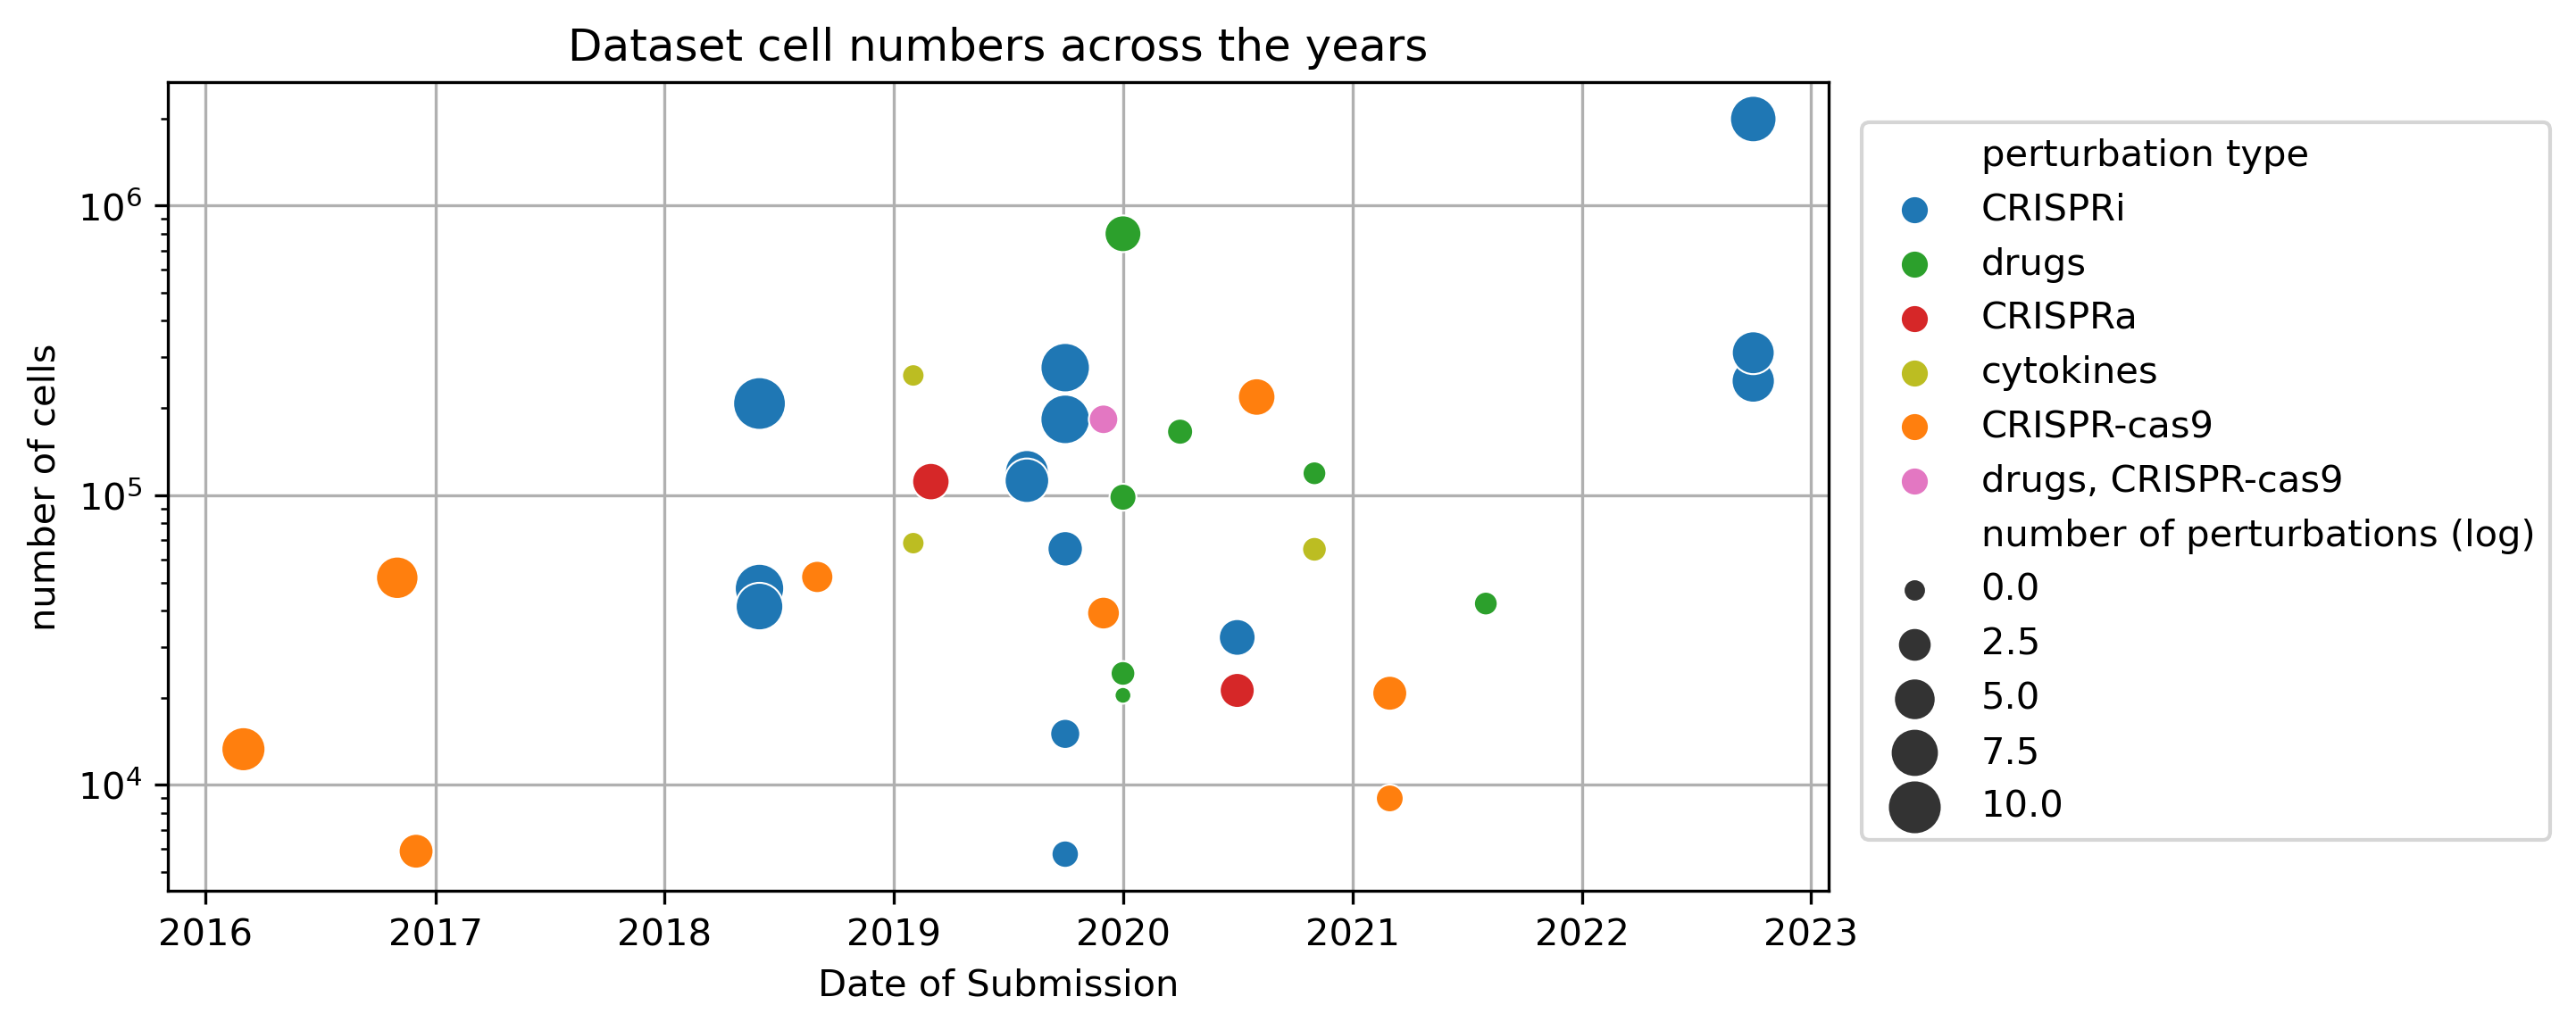

In [21]:
fig, ax = pl.subplots(figsize=[8,4], dpi=300)
sns.scatterplot(data=tab, x='Date of Submission', y='number of cells', hue='perturbation type', size='number of perturbations (log)', 
                sizes=(20,200), ax=ax, zorder=3, palette=colors_perturbation_types,)
pl.yscale('log')
ax.grid(which='major', zorder=-1)
pl.legend(bbox_to_anchor=(1.02, 0.95), loc='upper left', borderaxespad=0)
pl.title('Dataset cell numbers across the years')
pl.savefig(f'{supp_path}SuppFig3C_updated.pdf', bbox_inches='tight')
pl.show()


